In [5220]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

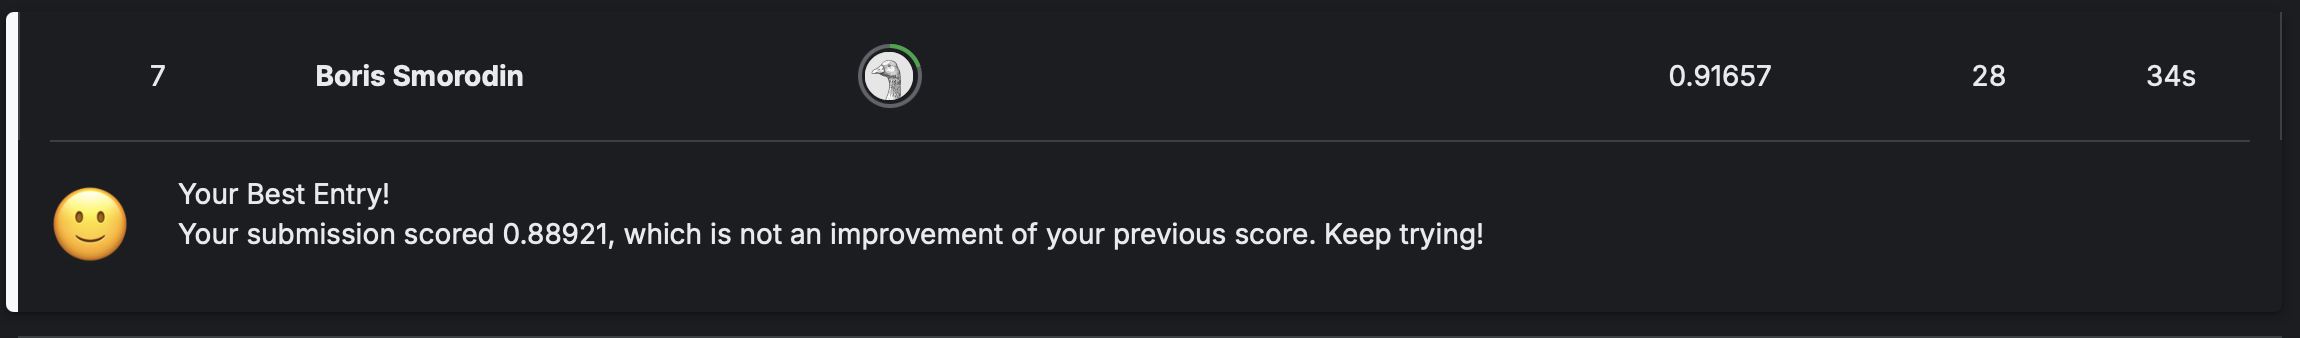

# Первичный анализ

In [5221]:
train = pd.read_csv("data/train_oil.csv")
test = pd.read_csv("data/oil_test.csv")

In [5222]:
train.head()

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION/EVAPORITE,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,OIL,DECLINING PRODUCTION,FORELAND,1870,CARBONIFEROUS,SANDSTONE,262.0,33.0,24.0,30.0
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,EXTENSION,-19.6017,-39.8332,PETROBRAS,ONSHORE,OIL,NEARLY DEPLETED,PASSIVE MARGIN,4843,PALEOGENE,SANDSTONE,2133.0,72.0,23.0,350.0
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION/EVAPORITE,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,6050,JURASSIC,LIMESTONE,250.0,184.0,21.0,410.0
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,EXTENSION,61.3833,1.7500,CNR,OFFSHORE,OIL,NEARLY DEPLETED,RIFT,8988,JURASSIC,SANDSTONE,425.0,300.0,22.0,750.0
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,53.2287,-115.8008,NUMEROUS,ONSHORE,OIL,UNKNOWN,FORELAND,9306,DEVONIAN,DOLOMITE,233.0,167.0,11.8,1407.0


In [5223]:
train.shape

(309, 20)

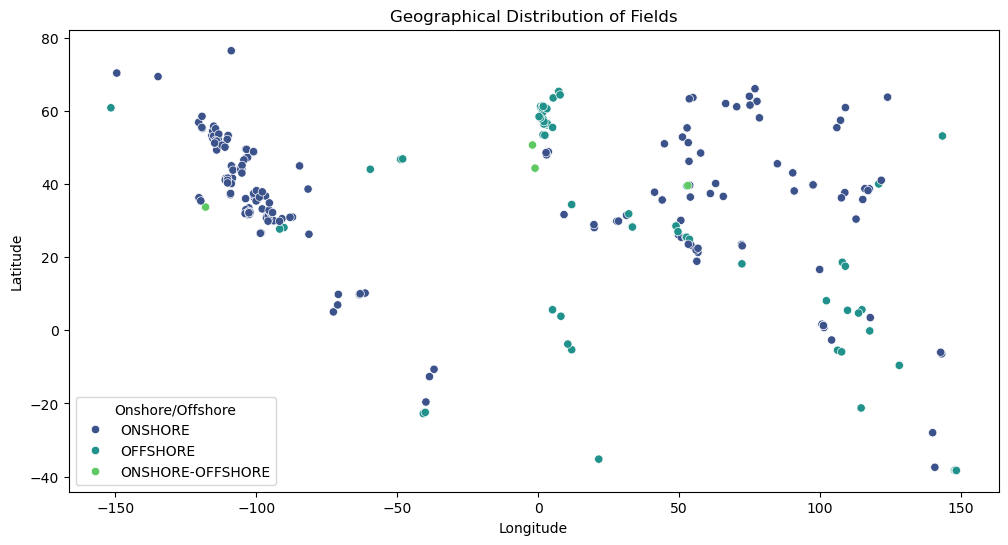

In [5224]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train, x="Longitude", y="Latitude", hue="Onshore/Offshore", palette="viridis")
plt.title("Geographical Distribution of Fields")
plt.show()

In [5225]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      309 non-null    object 
 1   Reservoir unit                  309 non-null    object 
 2   Country                         282 non-null    object 
 3   Region                          271 non-null    object 
 4   Basin name                      271 non-null    object 
 5   Tectonic regime                 309 non-null    object 
 6   Latitude                        282 non-null    float64
 7   Longitude                       279 non-null    float64
 8   Operator company                309 non-null    object 
 9   Onshore/Offshore                309 non-null    object 
 10  Hydrocarbon type                309 non-null    object 
 11  Reservoir status                309 non-null    object 
 12  Structural setting              309 

In [5226]:
null_count_train = train.isnull().sum() / len(train) * 100
null_count_test = test.isnull().sum() / len(train) * 100

In [5227]:
features_with_null_train = null_count_train[null_count_train > 0].index.to_list()
features_with_null_test = null_count_train[null_count_train > 0].index.to_list()

In [5228]:
features_with_null_train == features_with_null_test

True

In [5229]:
features_with_null_train

['Country', 'Region', 'Basin name', 'Latitude', 'Longitude']

<Axes: >

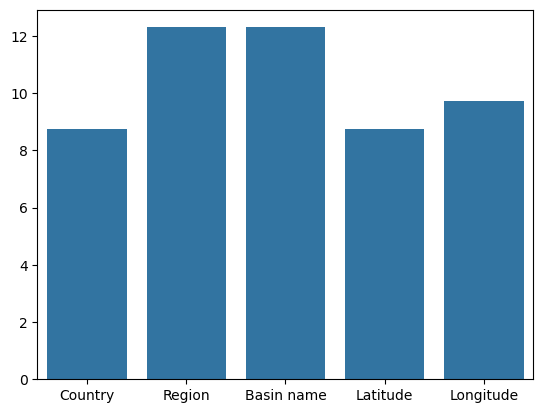

In [5230]:
sns.barplot({
    feature: null_count_train[feature] for feature in features_with_null_train
})

<Axes: >

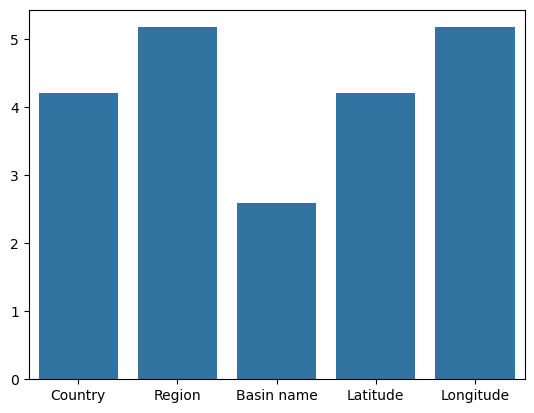

In [5231]:
sns.barplot({
    feature: null_count_test[feature] for feature in features_with_null_train
})

In [5232]:
test.isnull().sum() / len(train) * 100

Field name                        0.000000
Reservoir unit                    0.000000
Country                           4.207120
Region                            5.177994
Basin name                        2.588997
Tectonic regime                   0.000000
Latitude                          4.207120
Longitude                         5.177994
Operator company                  0.000000
Hydrocarbon type                  0.000000
Reservoir status                  0.000000
Structural setting                0.000000
Depth                             0.000000
Reservoir period                  0.000000
Lithology                         0.000000
Thickness (gross average ft)      0.000000
Thickness (net pay average ft)    0.000000
Porosity                          0.000000
Permeability                      0.000000
dtype: float64

## Предобработка

In [5233]:
def split_features_due_type(df: pd.DataFrame, dtype) -> list[str]:
    features_list = [column for column in df.columns if isinstance(df.dtypes[column], dtype)]
    return features_list

str_features = split_features_due_type(train, np.dtypes.ObjectDType)
str_features.remove("Onshore/Offshore")
float_features = split_features_due_type(train, np.dtypes.Float64DType)
int_features = split_features_due_type(train, np.dtypes.Int64DType)

In [5234]:
train[str_features]

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Operator company,Hydrocarbon type,Reservoir status,Structural setting,Reservoir period,Lithology
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION/EVAPORITE,NIZHNEVOLZHSKNET,OIL,DECLINING PRODUCTION,FORELAND,CARBONIFEROUS,SANDSTONE
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,EXTENSION,PETROBRAS,OIL,NEARLY DEPLETED,PASSIVE MARGIN,PALEOGENE,SANDSTONE
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION/EVAPORITE,SAUDI ARAMCO,OIL,REJUVENATING,FORELAND,JURASSIC,LIMESTONE
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,EXTENSION,CNR,OIL,NEARLY DEPLETED,RIFT,JURASSIC,SANDSTONE
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,NUMEROUS,OIL,UNKNOWN,FORELAND,DEVONIAN,DOLOMITE
...,...,...,...,...,...,...,...,...,...,...,...,...
304,HIDES,IMBURU-TORO,PAPUA NEW GUINEA,FAR EAST,PAPUAN FTB,COMPRESSION,OIL SEARCH LTD,GAS-CONDENSATE,CONTINUING DEVELOPMENT,THRUST,JURASSIC-CRETACEOUS,SANDSTONE
305,DRAKE POINT,DRAKE POINT-INTREPID INLET,CANADA,NORTH AMERICA,SVERDRUP,COMPRESSION/EVAPORITE/EXTENSION/LINKED,PANARCTIC OILS,GAS,UNDEVELOPED,FORELAND,JURASSIC,SANDSTONE
306,ALTAMONT-BLUEBELL,GREEN RIVER AND COLTON/WASATCH,USA,NORTH AMERICA,UINTA,COMPRESSION,NUMEROUS,OIL,MATURE PRODUCTION,FORELAND,PALEOGENE,SANDSTONE
307,BELL CREEK,MUDDY,USA,NORTH AMERICA,POWDER RIVER,COMPRESSION,SAMUEL GARY,OIL,NEARLY DEPLETED,FORELAND,CRETACEOUS,SANDSTONE


In [5235]:
train[str_features].nunique() / len(train) * 100

Field name            92.233010
Reservoir unit        83.495146
Country               13.592233
Region                 2.265372
Basin name            30.097087
Tectonic regime       17.799353
Operator company      44.660194
Hydrocarbon type       1.294498
Reservoir status       4.207120
Structural setting    13.915858
Reservoir period       7.119741
Lithology              4.207120
dtype: float64

Необходимо определить, какие признаки являются категориальными. Первичную оценку можно провести по проценту уникальных значений. Задаим трэшхолд 40%

In [5236]:
n_unique_percent = train[str_features].nunique() / len(train) * 100
to_drop_features = n_unique_percent[n_unique_percent > 40.0].index.tolist()
to_encode_features = n_unique_percent[n_unique_percent <= 40.0].index.tolist()
print(to_drop_features)
print(to_encode_features)

['Field name', 'Reservoir unit', 'Operator company']
['Country', 'Region', 'Basin name', 'Tectonic regime', 'Hydrocarbon type', 'Reservoir status', 'Structural setting', 'Reservoir period', 'Lithology']


Проверим связь категориальных признаков с целевой переменной

In [5237]:
chi_2_insignificant = []

for col in train[str_features].columns:
    contingency_table = pd.crosstab(train[col], train['Onshore/Offshore'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    if p_value > 0.05:
        chi_2_insignificant.append(col)
        
print(f"Связь данных признаков с таргетом статистически незначима: {chi_2_insignificant}")

Связь данных признаков с таргетом статистически незначима: ['Field name', 'Reservoir unit', 'Operator company', 'Hydrocarbon type']


Вычислим коэффициента Крамера для категориальных признаков. Ищем признаки, которые не имеют сильной значимой связи с таргетом (V < 0.5)

In [5238]:
cramer_insignificant = []

for col in train[str_features].columns:
    contingency_table = pd.crosstab(train[col], train['Onshore/Offshore'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramer_v = (chi2 / (n * min_dim)) ** 0.5

    if cramer_v < 0.5:
        cramer_insignificant.append(col)
print(f"Коэффицент Крамера < 0.5 для следующих признаков: {cramer_insignificant}")

Коэффицент Крамера < 0.5 для следующих признаков: ['Region', 'Hydrocarbon type', 'Reservoir status', 'Reservoir period', 'Lithology']


In [5239]:
to_drop_all = set(cramer_insignificant)
to_drop_all.update(set(chi_2_insignificant))
to_drop_all.update(set(to_drop_features))

print("Будут исключены следующие признаки:")
for it in to_drop_all:
    print(it)
    
to_drop_all = list(to_drop_all)

Будут исключены следующие признаки:
Lithology
Reservoir period
Region
Hydrocarbon type
Operator company
Reservoir status
Field name
Reservoir unit


In [5240]:
train = train.drop(columns=to_drop_all)
test = test.drop(columns=to_drop_all)
str_features = split_features_due_type(train, np.dtypes.ObjectDType)
str_features.remove("Onshore/Offshore")

In [5241]:
str_features

['Country', 'Basin name', 'Tectonic regime', 'Structural setting']

In [5242]:
train[float_features]

,Latitude,Longitude,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,51.0000,44.8042,262.0,33.0,24.0,30.0
1,-19.6017,-39.8332,2133.0,72.0,23.0,350.0
2,26.0800,49.8100,250.0,184.0,21.0,410.0
3,61.3833,1.7500,425.0,300.0,22.0,750.0
4,53.2287,-115.8008,233.0,167.0,11.8,1407.0
...,...,...,...,...,...,...
304,-6.0136,142.8409,490.0,240.0,10.0,100.0
305,76.4462,-108.9172,100.0,71.0,20.0,566.0
306,40.3000,-110.2100,8000.0,575.0,5.0,0.1
307,45.1039,-105.0967,45.0,23.0,28.5,2250.0


In [5243]:
train[int_features]

,Depth
0,1870
1,4843
2,6050
3,8988
4,9306
...,...
304,9905
305,3390
306,15250
307,4300


Количество пропусков невелико. 

Заполним пропуски по следующей стратегии: 

- числовые признаки - медианное значение
- категориальные - значение моды

In [5244]:
train[float_features] = train[float_features].fillna(train[float_features].median())
test[float_features] = test[float_features].fillna(train[float_features].median())

In [5245]:
num_imr = SimpleImputer(missing_values=np.nan, strategy='mean')
cat_imr = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train[str_features] = cat_imr.fit_transform(train[str_features])
test[str_features] = cat_imr.fit_transform(test[str_features])

In [5246]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Country                         309 non-null    object 
 1   Basin name                      309 non-null    object 
 2   Tectonic regime                 309 non-null    object 
 3   Latitude                        309 non-null    float64
 4   Longitude                       309 non-null    float64
 5   Onshore/Offshore                309 non-null    object 
 6   Structural setting              309 non-null    object 
 7   Depth                           309 non-null    int64  
 8   Thickness (gross average ft)    309 non-null    float64
 9   Thickness (net pay average ft)  309 non-null    float64
 10  Porosity                        309 non-null    float64
 11  Permeability                    309 non-null    float64
dtypes: float64(6), int64(1), object(5)
m

In [5247]:
target_enc_features = []
for col in str_features:
    try:
        le = LabelEncoder()
        try_train_col = le.fit_transform(train[col].astype(str))
        test[col] = le.transform(test[col].astype(str))
        train[col] = try_train_col
    except ValueError:
        print(col, "Error. В TEST встречено значение, не встреченное в train")
        target_enc_features.append(col)
print(target_enc_features)

Country Error. В TEST встречено значение, не встреченное в train
Basin name Error. В TEST встречено значение, не встреченное в train
Tectonic regime Error. В TEST встречено значение, не встреченное в train
Structural setting Error. В TEST встречено значение, не встреченное в train
['Country', 'Basin name', 'Tectonic regime', 'Structural setting']


Label encoder не отработал, поскольку в тестовой выборке встретились значения, которые не присутствуют в train. Попробуем применить One-Hot и Target

In [5248]:
train[str_features].nunique()

Country               42
Basin name            93
Tectonic regime       55
Structural setting    43
dtype: int64

Как видно, все признаки обладают высокой кардинальностью, поэтому ограничимся Target Encoder.
Также оставим копию датафрейма без энкодинга для работы с catboost и lightgbm

In [5249]:
te = TargetEncoder(
    cols=str_features,
    smoothing=10,
    min_samples_leaf=5
)

train_encoded = te.fit_transform(train[str_features], train['Onshore/Offshore'])
test_encoded = te.transform(test[str_features])

In [5250]:
num_cols = int_features + float_features
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])
train_encoded[num_cols] = scaler.fit_transform(train[num_cols])
test_encoded[num_cols] = scaler.transform(test[num_cols])

In [5251]:
test_encoded

,Country,Basin name,Tectonic regime,Structural setting,Depth,Latitude,Longitude,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,0.646352,0.849418,0.651514,0.375569,0.973528,-0.288161,0.482770,-0.011161,-0.140823,-1.092988,-0.469689
1,0.646352,0.636639,0.636639,0.636639,1.033436,-0.208062,0.517738,-0.185751,0.803124,0.303770,-0.177257
2,0.855869,0.855869,0.921076,0.862384,-0.208621,0.596510,0.838341,-0.340366,-0.279221,-1.092988,-0.457672
3,0.190841,0.244832,0.584271,0.375569,0.837699,1.177858,0.156633,0.093148,0.568912,-0.115257,0.023039
4,0.768932,0.862384,0.855869,0.441750,-1.050646,-0.672703,1.024205,-0.066645,-0.651832,0.443446,-0.227331
...,...,...,...,...,...,...,...,...,...,...,...
128,0.829544,0.816641,0.651514,0.375569,-0.216903,0.097907,1.578955,-0.148022,-0.360841,-2.140557,-0.469289
129,0.943918,0.843062,0.849418,0.843062,1.199356,-0.037667,-1.317166,-0.414345,-0.119531,0.303770,-0.402590
130,0.829544,0.816641,0.651514,0.375569,-0.378682,0.111759,1.562217,-0.392151,-0.406973,1.239598,1.397072
131,0.829544,0.816641,0.651514,0.375569,-0.561719,0.111759,1.562217,-0.440977,-0.431814,0.750733,-0.356522


In [5252]:
train["Onshore/Offshore"].value_counts()

Onshore/Offshore
ONSHORE             218
OFFSHORE             86
ONSHORE-OFFSHORE      5
Name: count, dtype: int64

## Feature Engineering

Введём 2 новых признака:
1. Географический кластер (число выделено визуально с карты) при помощи кластериазции
2. Производенеие пористости на глубину

In [5253]:
coords = train[["Latitude", "Longitude"]]
kmeans = KMeans(n_clusters=5, random_state=42)
train["geo_cluster"] = kmeans.fit_predict(coords)
test["geo_cluster"] = kmeans.predict(test[["Latitude", "Longitude"]])
train_encoded["geo_cluster"] = train["geo_cluster"]
test_encoded["geo_cluster"] = test["geo_cluster"]

In [5254]:
train["depth_porosity"] = train["Depth"] * train["Porosity"]
test["depth_porosity"] = test["Depth"] * test["Porosity"]
train_encoded["depth_porosity"] = train["depth_porosity"]
test_encoded["depth_porosity"] = test["depth_porosity"]

## Корреляционный анализ и анализ важности признаков

In [5255]:
train["Onshore/Offshore"] = LabelEncoder().fit_transform(train["Onshore/Offshore"])
train_encoded["Onshore/Offshore"] = train["Onshore/Offshore"]

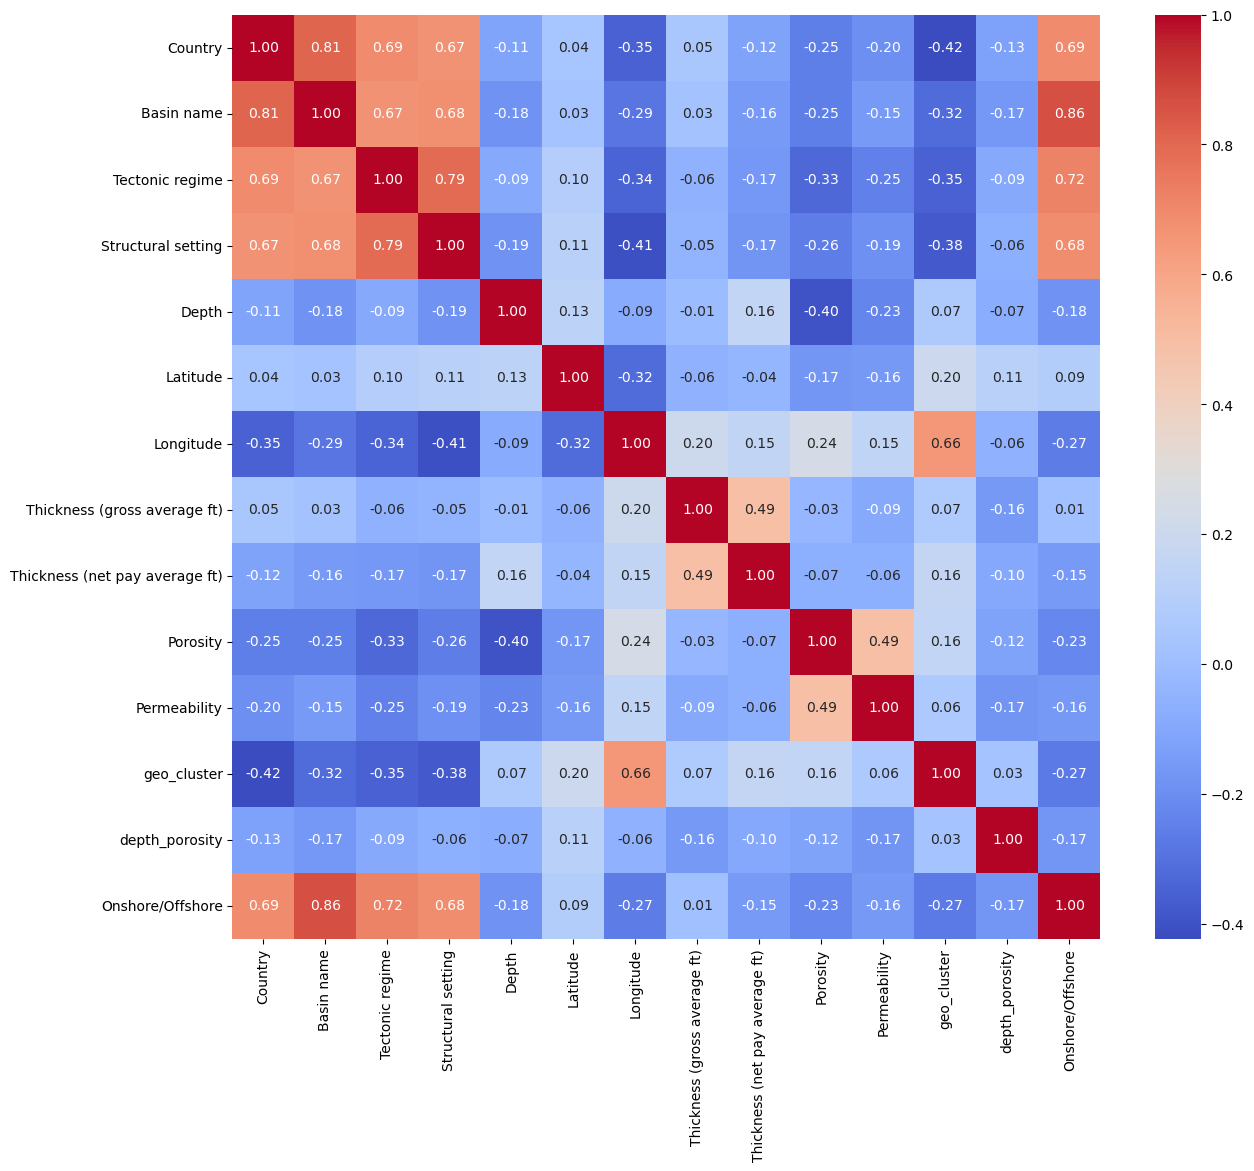

In [5256]:
corr_matrix = train_encoded.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(
    data=corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f"
    )
plt.show()

In [5257]:
high_corr_pairs = []
low_corr_target_features = []
important_features = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            if corr_matrix.columns[i] == "Onshore/Offshore":
                important_features.append(corr_matrix.columns[j])
                
            elif corr_matrix.columns[j] == "Onshore/Offshore":
                important_features.append(corr_matrix.columns[i])
                
            else:
                high_corr_pairs.append(pair)
                
        elif abs(corr_matrix.iloc[i, j]) <= 0.1:
            if corr_matrix.columns[i] == "Onshore/Offshore":
                low_corr_target_features.append(corr_matrix.columns[j])
                
            elif corr_matrix.columns[j] == "Onshore/Offshore":
                low_corr_target_features.append(corr_matrix.columns[i])
            
        else:
            continue
        

print("\nПары признаков с корреляцией > 0.7:")
for pair in high_corr_pairs:
    print(f"{pair[0]} и {pair[1]}: {pair[2]:.2f}")
    
print("\nПары признаков с корреляцией <= 0.1 (с таргетом):")
for it in low_corr_target_features:
    print(it)
    
print("\nСписок важных фичей")
for it in important_features:
    print(it)


Пары признаков с корреляцией > 0.7:
Country и Basin name: 0.81
Tectonic regime и Structural setting: 0.79

Пары признаков с корреляцией <= 0.1 (с таргетом):
Latitude
Thickness (gross average ft)

Список важных фичей
Basin name
Tectonic regime


Найдено 2 пары признаков с подозрением на мультиколлинеарность
Из них предварительно удалению подлежат Country и Structural setting, так как остальные фичи важны.

Latitude и Thickness подлежат удалению 

In [5258]:
y_train = train["Onshore/Offshore"]
X_train = train.drop(columns=["Onshore/Offshore"])
X_train_encoded = train_encoded.drop(columns=["Onshore/Offshore"])

Дополнительно проверим важность признаков при помощи RF

<Axes: >

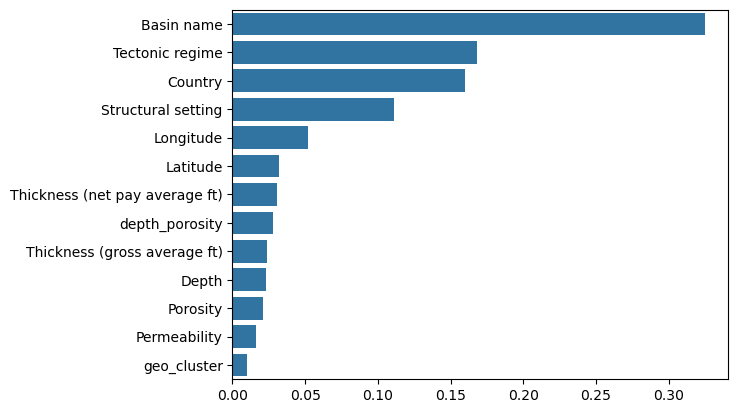

In [5259]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_encoded, y_train)
importance = pd.Series(model.feature_importances_, index=X_train_encoded.columns)
top_features = importance.sort_values(ascending=False).index
sns.barplot(importance.sort_values(ascending=False), orient="y")


Как видно, RF оценивает важность Latitude выше, чем geo_cluster. Однако из матрицы корреляций видно, что корреляция с таргетом для Latitude существенно ниже.

Удаляем.

Также удалим Country, чтобы не допустить мультиколлинеарности

In [5260]:
structural_setting_train = X_train["Structural setting"]
structural_setting_test = test["Structural setting"]
X_train = X_train.drop(columns=[
    "Country",
    "Latitude",
    "Thickness (gross average ft)"
    ])
test = test.drop(columns=[
    "Country",
    "Latitude",
    "Thickness (gross average ft)"
    ])

X_train_encoded = X_train_encoded.drop(columns=[
    "Country",
    "Latitude",
    "Thickness (gross average ft)"
    ])

test_encoded = test_encoded.drop(columns=[
    "Country",
    "Latitude",
    "Thickness (gross average ft)"
    ])

Проверка

In [5261]:
corr_matrix = X_train_encoded.corr()
high_corr_pairs = []
low_corr_target_features = []
important_features = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            if corr_matrix.columns[i] == "Onshore/Offshore":
                important_features.append(corr_matrix.columns[j])
                
            elif corr_matrix.columns[j] == "Onshore/Offshore":
                important_features.append(corr_matrix.columns[i])
                
            else:
                high_corr_pairs.append(pair)
                
        elif abs(corr_matrix.iloc[i, j]) <= 0.1:
            if corr_matrix.columns[i] == "Onshore/Offshore":
                low_corr_target_features.append(corr_matrix.columns[j])
                
            elif corr_matrix.columns[j] == "Onshore/Offshore":
                low_corr_target_features.append(corr_matrix.columns[i])
            
        else:
            continue
        

print("\nПары признаков с корреляцией > 0.7:")
for pair in high_corr_pairs:
    print(f"{pair[0]} и {pair[1]}: {pair[2]:.2f}")
    
print("\nПары признаков с корреляцией <= 0.1 (с таргетом):")
for it in low_corr_target_features:
    print(it)
    
print("\nСписок важных фичей")
for it in important_features:
    print(it)


Пары признаков с корреляцией > 0.7:
Tectonic regime и Structural setting: 0.79

Пары признаков с корреляцией <= 0.1 (с таргетом):

Список важных фичей


<Axes: >

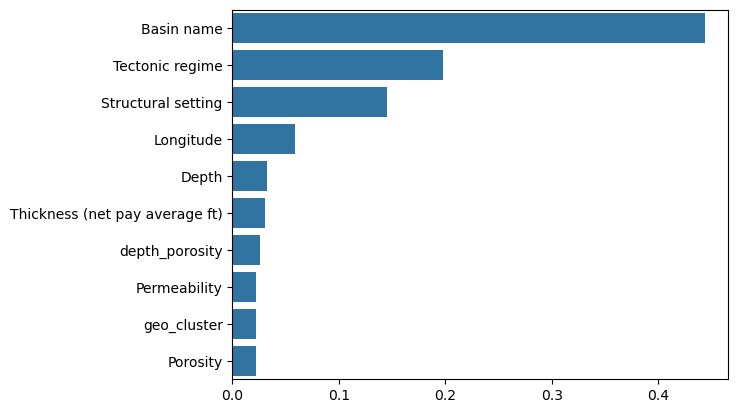

In [5262]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_encoded, y_train)
importance = pd.Series(model.feature_importances_, index=X_train_encoded.columns)
top_features = importance.sort_values(ascending=False).index
sns.barplot(importance.sort_values(ascending=False), orient="y")

## Бейзлайн

In [5263]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb.fit(X_train_encoded, y_train)

/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:50:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [5264]:
xgb_pred = xgb.predict(test_encoded)
output_df = pd.DataFrame({"Onshore/Offshore": xgb_pred})
output_df.to_csv("data/homework_3_baseline_xgb.csv", index_label="index")

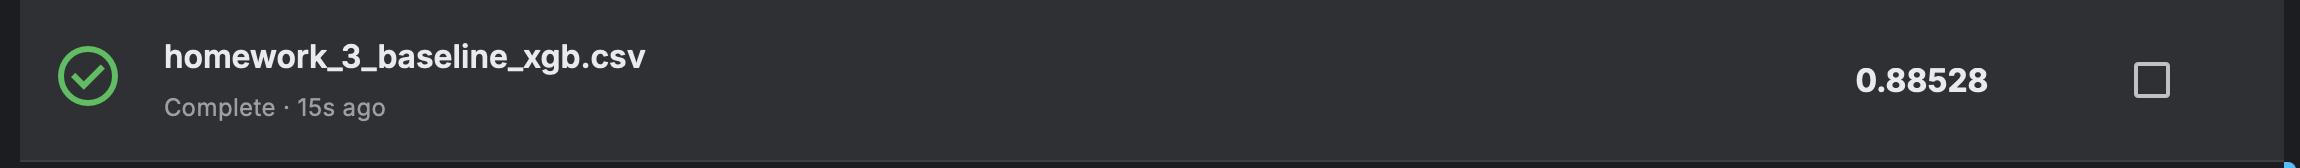

Результат хороший, но можно улучшить

Попробуем:
1. Различные модели в качестве бейзлайнов
2. Оптимизацию 3-х лучших моделей
3. Кросс-валидацию

1. Попробуем другие модели

In [5265]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_encoded, y_train)
lr_pred = lr.predict(test_encoded)
output_df = pd.DataFrame({"Onshore/Offshore": lr_pred})
output_df.to_csv("data/homework_3_baseline_logreg.csv", index_label="index")

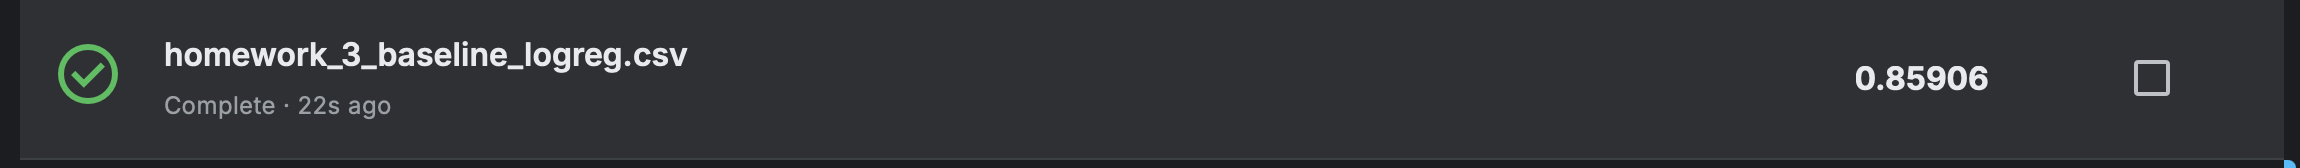

In [5266]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_encoded, y_train)
rf_pred = rf.predict(test_encoded)
output_df = pd.DataFrame({"Onshore/Offshore": rf_pred})
output_df.to_csv("data/homework_3_baseline_rf.csv", index_label="index")

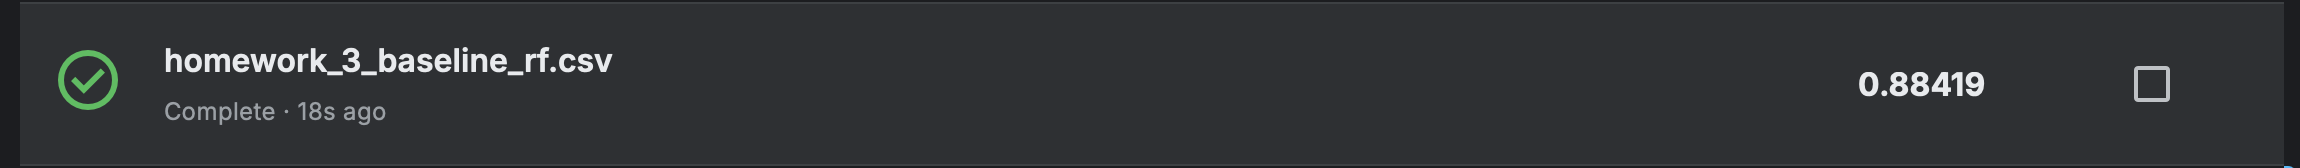

In [5267]:
cat_features = split_features_due_type(X_train, np.dtypes.ObjectDType)

In [5268]:
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Basin name                      309 non-null    float64
 1   Tectonic regime                 309 non-null    float64
 2   Structural setting              309 non-null    float64
 3   Depth                           309 non-null    float64
 4   Longitude                       309 non-null    float64
 5   Thickness (net pay average ft)  309 non-null    float64
 6   Porosity                        309 non-null    float64
 7   Permeability                    309 non-null    float64
 8   geo_cluster                     309 non-null    int32  
 9   depth_porosity                  309 non-null    float64
dtypes: float64(9), int32(1)
memory usage: 23.1 KB


In [5269]:
X_train

,Basin name,Tectonic regime,Longitude,Structural setting,Depth,Thickness (net pay average ft),Porosity,Permeability,geo_cluster,depth_porosity
0,VOLGA-URAL,COMPRESSION/EVAPORITE,0.681575,FORELAND,-1.348806,-0.534726,0.862473,-0.447657,4,-1.163309
1,ESPIRITO SANTO,EXTENSION,-0.349973,PASSIVE MARGIN,-0.528038,-0.396327,0.722798,-0.127183,2,-0.381665
2,THE GULF,COMPRESSION/EVAPORITE,0.742585,FORELAND,-0.194817,0.001124,0.443446,-0.067094,3,-0.086391
3,NORTH SEA NORTHERN,EXTENSION,0.156837,RIFT,0.616288,0.412770,0.583122,0.273410,4,0.359371
4,WESTERN CANADA,COMPRESSION,-1.275854,FORELAND,0.704080,-0.059203,-0.841572,0.931383,0,-0.592533
...,...,...,...,...,...,...,...,...,...,...
304,PAPUAN FTB,COMPRESSION,1.876431,THRUST,0.869448,0.199850,-1.092988,-0.377553,1,-0.950296
305,SVERDRUP,COMPRESSION/EVAPORITE/EXTENSION/LINKED,-1.191958,FORELAND,-0.929174,-0.399876,0.303770,0.089137,0,-0.282255
306,UINTA,COMPRESSION,-1.207714,FORELAND,2.345063,1.388656,-1.791367,-0.477601,0,-4.200869
307,POWDER RIVER,COMPRESSION,-1.145394,FORELAND,-0.677946,-0.570212,1.491015,1.775632,0,-1.010828


In [5270]:
cb = CatBoostClassifier(verbose=0, random_state=42)
cb.fit(X_train, y_train, cat_features=cat_features, verbose=False)
cb_pred = cb.predict(test)
cb_pred = np.array([it[0] for it in cb_pred])
output_df = pd.DataFrame({"Onshore/Offshore": cb_pred})
output_df.to_csv("data/homework_3_baseline_cb.csv", index_label="index")

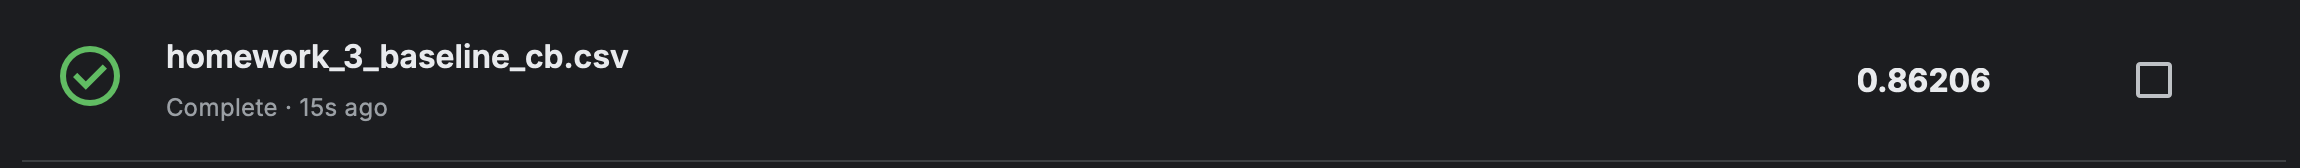

## Оптимизация и выбор модели

In [5271]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [5278]:
def optimize_model(model_name, X, y, n_trials=100):
    
    def objective(trial):
        if model_name == "LogisticRegression":
            params = {
                "C": trial.suggest_float("C", 0.01, 10, log=True),
                "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
                "solver": "saga",
                "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"])
            }
            
        elif model_name == "RandomForest":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "max_depth": trial.suggest_int("max_depth", 3, 20),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
                "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"])
            }
            
        elif model_name == "XGBoost":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "max_depth": trial.suggest_int("max_depth", 3, 12),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
                "gamma": trial.suggest_float("gamma", 0, 5),
                "tree_method": "exact",
                "eval_metric": trial.suggest_categorical("eval_metric", ["mlogloss"])
            }
            
        elif model_name == "CatBoost":
            params = {
                "iterations": trial.suggest_int("iterations", 50, 300),
                "depth": trial.suggest_int("depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
                "random_strength": trial.suggest_float("random_strength", 0.1, 1.0),
                "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 1.0),
                "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"])
            }
        else:
            raise ValueError(f"Model {model_name} not supported")

        if model_name == "LogisticRegression":
            model = LogisticRegression(**params, max_iter=1000, random_state=42)
            
        elif model_name == "RandomForest":
            model = RandomForestClassifier(**params, random_state=42)
            
        elif model_name == "XGBoost":
            model = XGBClassifier(**params, random_state=42)
            
        elif model_name == "CatBoost":
            model = CatBoostClassifier(**params, verbose=0, random_state=42)

        scores = []
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            if model_name == "CatBoost":
                model.fit(X_train, y_train, cat_features=cat_features)
            else:
                model.fit(X_train, y_train)
                
            preds = model.predict(X_val)
            scores.append(f1_score(y_val, preds, average="macro"))

        return np.mean(scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params, study.best_value

In [5273]:
X_train[cat_features]

,Basin name,Tectonic regime,Structural setting
0,VOLGA-URAL,COMPRESSION/EVAPORITE,FORELAND
1,ESPIRITO SANTO,EXTENSION,PASSIVE MARGIN
2,THE GULF,COMPRESSION/EVAPORITE,FORELAND
3,NORTH SEA NORTHERN,EXTENSION,RIFT
4,WESTERN CANADA,COMPRESSION,FORELAND
...,...,...,...
304,PAPUAN FTB,COMPRESSION,THRUST
305,SVERDRUP,COMPRESSION/EVAPORITE/EXTENSION/LINKED,FORELAND
306,UINTA,COMPRESSION,FORELAND
307,POWDER RIVER,COMPRESSION,FORELAND


In [5279]:
best_params_xgb, best_score_xgb = optimize_model("XGBoost", X_train_encoded, y_train)
print(f"Best params: {best_params_xgb}")
print(f"Best F1-score: {best_score_xgb:.4f}")

final_model_xgb = XGBClassifier(
    **best_params_xgb,
    # eval_metric="logloss"
    )
final_model_xgb.fit(X_train_encoded, y_train)

preds_xgb = final_model_xgb.predict(test_encoded)
output_df = pd.DataFrame({"Onshore/Offshore": preds_xgb})
output_df.to_csv("data/homework_3_optimized_xgb.csv", index_label="index")

[I 2025-06-13 03:06:35,269] A new study created in memory with name: no-name-26fec865-72f6-4bcb-8335-db2012ad2537


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-13 03:06:36,039] Trial 0 finished with value: 0.611872826501896 and parameters: {'n_estimators': 94, 'max_depth': 4, 'learning_rate': 0.2118760394470775, 'subsample': 0.6838725514394851, 'colsample_bytree': 0.8731928356050562, 'min_child_weight': 8, 'gamma': 3.215706016340494, 'eval_metric': 'mlogloss'}. Best is trial 0 with value: 0.611872826501896.
[I 2025-06-13 03:06:37,595] Trial 1 finished with value: 0.6250716243422527 and parameters: {'n_estimators': 174, 'max_depth': 6, 'learning_rate': 0.2216969585584016, 'subsample': 0.609902778519425, 'colsample_bytree': 0.8802750929843776, 'min_child_weight': 3, 'gamma': 1.2201183708236873, 'eval_metric': 'mlogloss'}. Best is trial 1 with value: 0.6250716243422527.
[I 2025-06-13 03:06:38,200] Trial 2 finished with value: 0.6247926440632725 and parameters: {'n_estimators': 70, 'max_depth': 11, 'learning_rate': 0.12613806670716293, 'subsample': 0.7663195208843263, 'colsample_bytree': 0.786436350643937, 'min_child_weight': 6, 'gamma

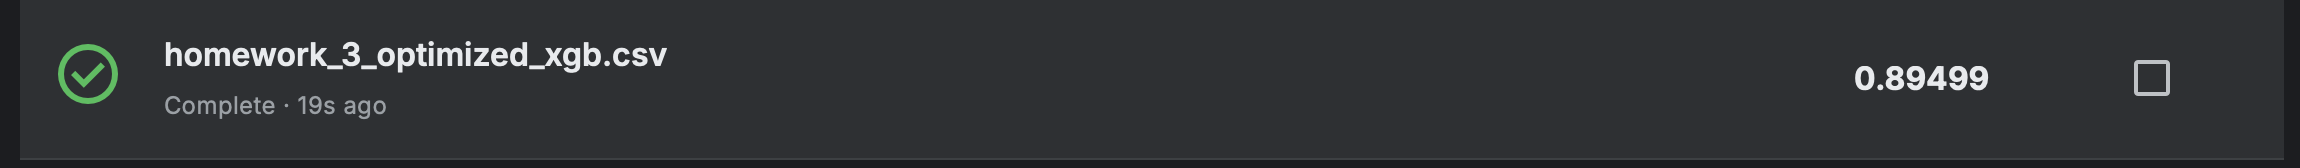

In [5275]:
best_params_rf, best_score_rf = optimize_model("RandomForest", X_train_encoded, y_train)
print(f"Best params: {best_params_rf}")
print(f"Best F1-score: {best_score_rf:.4f}")

final_model_rf = RandomForestClassifier(**best_params_rf, random_state=42)
final_model_rf.fit(X_train_encoded, y_train)

preds_rf = final_model_rf.predict(test_encoded)
output_df = pd.DataFrame({"Onshore/Offshore": preds_rf})
output_df.to_csv("data/homework_3_optimized_rf.csv", index_label="index")

[I 2025-06-13 02:53:45,098] A new study created in memory with name: no-name-8a157666-ed24-4eab-a5c5-5ccc11f596ea


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-13 02:53:45,490] Trial 0 finished with value: 0.6272921583404866 and parameters: {'n_estimators': 108, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 3, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6272921583404866.
[I 2025-06-13 02:53:45,988] Trial 1 finished with value: 0.6301543949386783 and parameters: {'n_estimators': 155, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 9, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6301543949386783.
[I 2025-06-13 02:53:46,664] Trial 2 finished with value: 0.6327440094334318 and parameters: {'n_estimators': 186, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 3, 'class_weight': None}. Best is trial 2 with value: 0.6327440094334318.
[I 2025-06-13 02:53:47,492] Trial 3 finished with value: 0.6327628220334505 and parameters: {'n_estimators': 265, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 8, 'class_weight': None}. Best is trial 3 with value: 0.632762822033

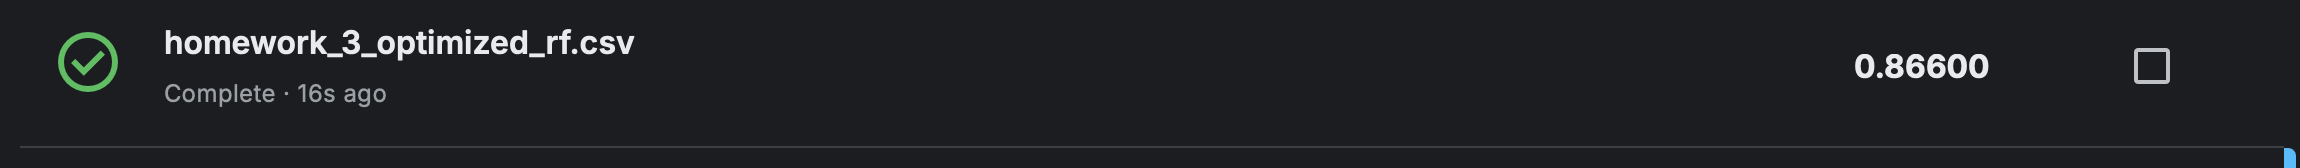

In [5276]:
best_params_logreg, best_score_logreg = optimize_model("LogisticRegression", X_train_encoded, y_train)
print(f"Best params: {best_params_logreg}")
print(f"Best F1-score: {best_score_logreg:.4f}")

final_model_logreg = XGBClassifier(**best_params_logreg, random_state=42)
final_model_logreg.fit(X_train_encoded, y_train)

preds_logreg = final_model_logreg.predict(test_encoded)
output_df = pd.DataFrame({"Onshore/Offshore": preds_logreg})
output_df.to_csv("data/homework_3_optimized_logreg.csv", index_label="index")

[I 2025-06-13 02:54:39,601] A new study created in memory with name: no-name-3f60bc3e-16c2-401d-81c0-8289081c774c


  0%|          | 0/100 [00:00<?, ?it/s]

/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:39,917] Trial 0 finished with value: 0.6104923047775339 and parameters: {'C': 2.1419475565970756, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6104923047775339.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:40,151] Trial 1 finished with value: 0.6334527297951758 and parameters: {'C': 5.393517782504627, 'penalty': 'l1', 'class_weight': None}. Best is trial 1 with value: 0.6334527297951758.
[I 2025-06-13 02:54:40,327] Trial 2 finished with value: 0.5164878550162476 and parameters: {'C': 0.14978959288219537, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6334527297951758.
[I 2025-06-13 02:54:40,445] Trial 3 finished with value: 0.6324838417544701 and parameters: {'C': 1.6404794495338535, 'penalty': 'l2', 'class_weight': None}. Best is trial 1 with value: 0.6334527297951758.
[I 2025-06-13 02:54:40,477] Trial 4 finished with value: 0.48785036763256506 and parameters: {'C': 0.01778687783778304, 'penalty': 'l2', 'class_weight': None}. Best is trial 1 with value: 0.6334527297951758.
[I 2025-06-13 02:54:40,605] Trial 5 finished with value: 0.6332158812505546 and parameters: {'C': 1.9305898622723165, 'penalty': 'l2', 'class_weight': None}. Best is tr

/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:40,674] Trial 6 finished with value: 0.6203391615679434 and parameters: {'C': 0.4558163345415155, 'penalty': 'l2', 'class_weight': None}. Best is trial 1 with value: 0.6334527297951758.
[I 2025-06-13 02:54:40,862] Trial 7 finished with value: 0.6209024221142261 and parameters: {'C': 0.21445202404284927, 'penalty': 'l1', 'class_weight': None}. Best is trial 1 with value: 0.6334527297951758.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:41,103] Trial 8 finished with value: 0.6215964016264743 and parameters: {'C': 2.8828390170848324, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6334527297951758.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:41,345] Trial 9 finished with value: 0.607004710643542 and parameters: {'C': 1.9851355485891322, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6334527297951758.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:41,582] Trial 10 finished with value: 0.6363155151579611 and parameters: {'C': 8.905040565435915, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:41,810] Trial 11 finished with value: 0.6363155151579611 and parameters: {'C': 9.59014998937163, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:42,041] Trial 12 finished with value: 0.6363155151579611 and parameters: {'C': 9.514774117721096, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:42,271] Trial 13 finished with value: 0.6363155151579611 and parameters: {'C': 8.395325737982128, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:42,496] Trial 14 finished with value: 0.6266120408839903 and parameters: {'C': 0.6552101440991455, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.
[I 2025-06-13 02:54:42,571] Trial 15 finished with value: 0.4829784946735412 and parameters: {'C': 0.07278104629835028, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:42,797] Trial 16 finished with value: 0.6297349955356967 and parameters: {'C': 0.8317954795834214, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:43,030] Trial 17 finished with value: 0.6304670350317811 and parameters: {'C': 4.719813639602624, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:43,273] Trial 18 finished with value: 0.4672404935394958 and parameters: {'C': 0.09144671626494491, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 10 with value: 0.6363155151579611.
[I 2025-06-13 02:54:43,296] Trial 19 finished with value: 0.2757691155804363 and parameters: {'C': 0.015774778278524405, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:43,520] Trial 20 finished with value: 0.6304670350317811 and parameters: {'C': 4.312956388195358, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:43,744] Trial 21 finished with value: 0.6363155151579611 and parameters: {'C': 7.611068122592192, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:43,967] Trial 22 finished with value: 0.6363155151579611 and parameters: {'C': 9.591364650025085, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:44,192] Trial 23 finished with value: 0.6304670350317811 and parameters: {'C': 3.948636435229419, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:44,415] Trial 24 finished with value: 0.6325898049205787 and parameters: {'C': 1.2050309850899337, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:44,724] Trial 25 finished with value: 0.6363155151579611 and parameters: {'C': 9.72545323034211, 'penalty': 'l1', 'class_weight': None}. Best is trial 10 with value: 0.6363155151579611.
[I 2025-06-13 02:54:44,904] Trial 26 finished with value: 0.6439748141015593 and parameters: {'C': 3.1381672208807894, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:45,084] Trial 27 finished with value: 0.6153209995738343 and parameters: {'C': 3.331851559553656, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.
[I 2025-06-13 02:54:45,264] Trial 28 finished with value: 0.5651573583553074 and parameters: {'C': 1.081507929311924, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:45,442] Trial 29 finished with value: 0.5954913122131135 and parameters: {'C': 5.600618753797068, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.
[I 2025-06-13 02:54:45,622] Trial 30 finished with value: 0.6264265780786248 and parameters: {'C': 2.55473768463998, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:45,883] Trial 31 finished with value: 0.6135119344847315 and parameters: {'C': 6.247361174459065, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.
[I 2025-06-13 02:54:46,062] Trial 32 finished with value: 0.6341691975652182 and parameters: {'C': 6.031923143894639, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:46,292] Trial 33 finished with value: 0.6363155151579611 and parameters: {'C': 9.675849959118882, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.
[I 2025-06-13 02:54:46,464] Trial 34 finished with value: 0.6334527297951758 and parameters: {'C': 3.4508736037820826, 'penalty': 'l2', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:46,707] Trial 35 finished with value: 0.6170816580544551 and parameters: {'C': 5.7715502711639095, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.
[I 2025-06-13 02:54:46,823] Trial 36 finished with value: 0.6324838417544701 and parameters: {'C': 1.4556393554880462, 'penalty': 'l2', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.
[I 2025-06-13 02:54:46,865] Trial 37 finished with value: 0.5217180455734501 and parameters: {'C': 0.029343067587545374, 'penalty': 'l2', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:47,082] Trial 38 finished with value: 0.6237572314991081 and parameters: {'C': 0.5081618511754996, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.
[I 2025-06-13 02:54:47,263] Trial 39 finished with value: 0.6049560694890844 and parameters: {'C': 2.4315645743499514, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:47,474] Trial 40 finished with value: 0.6209024221142261 and parameters: {'C': 0.3538100787569129, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:47,702] Trial 41 finished with value: 0.6363155151579611 and parameters: {'C': 6.841651776241063, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:47,930] Trial 42 finished with value: 0.6363155151579611 and parameters: {'C': 7.775992639581246, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:48,157] Trial 43 finished with value: 0.6304670350317811 and parameters: {'C': 4.371727330282166, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:48,384] Trial 44 finished with value: 0.6363155151579611 and parameters: {'C': 8.035367406345744, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:48,611] Trial 45 finished with value: 0.6325898049205787 and parameters: {'C': 1.972447769831419, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:48,907] Trial 46 finished with value: 0.6304670350317811 and parameters: {'C': 4.998660648674075, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:49,134] Trial 47 finished with value: 0.6304670350317811 and parameters: {'C': 3.0454366271814477, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:49,373] Trial 48 finished with value: 0.6207275711740525 and parameters: {'C': 7.765552877677712, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.
[I 2025-06-13 02:54:49,547] Trial 49 finished with value: 0.6334527297951758 and parameters: {'C': 4.232449000619289, 'penalty': 'l2', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:49,721] Trial 50 finished with value: 0.6176259683712966 and parameters: {'C': 0.16827243989404078, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:49,950] Trial 51 finished with value: 0.6363155151579611 and parameters: {'C': 7.522710787981461, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:50,175] Trial 52 finished with value: 0.6363155151579611 and parameters: {'C': 9.482921805210436, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:50,402] Trial 53 finished with value: 0.6304670350317811 and parameters: {'C': 5.242785481019808, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:50,630] Trial 54 finished with value: 0.6363155151579611 and parameters: {'C': 7.401666969979975, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:50,857] Trial 55 finished with value: 0.6304670350317811 and parameters: {'C': 3.490118709863526, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:51,084] Trial 56 finished with value: 0.6334527297951758 and parameters: {'C': 5.890320367496348, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:51,330] Trial 57 finished with value: 0.6116184152572466 and parameters: {'C': 2.6635097795554654, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:51,556] Trial 58 finished with value: 0.6363155151579611 and parameters: {'C': 9.876376273633909, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.
[I 2025-06-13 02:54:51,682] Trial 59 finished with value: 0.6324838417544701 and parameters: {'C': 1.697482171026638, 'penalty': 'l2', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:51,923] Trial 60 finished with value: 0.6135119344847315 and parameters: {'C': 4.392279492321882, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.
[I 2025-06-13 02:54:51,942] Trial 61 finished with value: 0.2757691155804363 and parameters: {'C': 0.010684049811994887, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:52,168] Trial 62 finished with value: 0.6363155151579611 and parameters: {'C': 9.407889831089456, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:52,394] Trial 63 finished with value: 0.6363155151579611 and parameters: {'C': 6.9732117405514025, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:52,621] Trial 64 finished with value: 0.6304670350317811 and parameters: {'C': 5.2436840752006315, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:52,849] Trial 65 finished with value: 0.6363155151579611 and parameters: {'C': 9.976124641903759, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.
[I 2025-06-13 02:54:52,900] Trial 66 finished with value: 0.5551270776949894 and parameters: {'C': 0.09122078776826874, 'penalty': 'l2', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:53,093] Trial 67 finished with value: 0.4223390781234736 and parameters: {'C': 0.04350182980574134, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:53,322] Trial 68 finished with value: 0.6363155151579611 and parameters: {'C': 6.572120179919583, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.
[I 2025-06-13 02:54:53,496] Trial 69 finished with value: 0.6334527297951758 and parameters: {'C': 3.829390619052622, 'penalty': 'l2', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:53,735] Trial 70 finished with value: 0.629899860872658 and parameters: {'C': 8.133650973216536, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:53,963] Trial 71 finished with value: 0.6334527297951758 and parameters: {'C': 6.043675312911201, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:54,189] Trial 72 finished with value: 0.6363155151579611 and parameters: {'C': 8.466903985641801, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:54,417] Trial 73 finished with value: 0.6304670350317811 and parameters: {'C': 4.89255985299697, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:54,648] Trial 74 finished with value: 0.6363155151579611 and parameters: {'C': 6.588924008745811, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:54,943] Trial 75 finished with value: 0.6363155151579611 and parameters: {'C': 9.829026383685562, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.
[I 2025-06-13 02:54:55,033] Trial 76 finished with value: 0.6293608871027637 and parameters: {'C': 0.8358634162653585, 'penalty': 'l2', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:55,257] Trial 77 finished with value: 0.6363155151579611 and parameters: {'C': 8.318818011490878, 'penalty': 'l1', 'class_weight': None}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:55,502] Trial 78 finished with value: 0.6370988498648776 and parameters: {'C': 3.0383143057587882, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:55,746] Trial 79 finished with value: 0.6311948019444131 and parameters: {'C': 3.0161605498616244, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.
[I 2025-06-13 02:54:55,925] Trial 80 finished with value: 0.5923699609334492 and parameters: {'C': 2.2217528034784, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.6439748141015593.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:54:56,170] Trial 81 finished with value: 0.6499946335764082 and parameters: {'C': 1.2551233495032064, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 81 with value: 0.6499946335764082.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:56,419] Trial 82 finished with value: 0.5759026459091466 and parameters: {'C': 0.587756078279047, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 81 with value: 0.6499946335764082.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:56,664] Trial 83 finished with value: 0.6163213251448545 and parameters: {'C': 1.494906875910709, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 81 with value: 0.6499946335764082.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:56,910] Trial 84 finished with value: 0.6540265614338331 and parameters: {'C': 1.1564033246771253, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 84 with value: 0.6540265614338331.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:57,160] Trial 85 finished with value: 0.663109450617973 and parameters: {'C': 1.0916345802012921, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:57,409] Trial 86 finished with value: 0.662980299678249 and parameters: {'C': 1.0917370544258902, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:57,658] Trial 87 finished with value: 0.621738863975706 and parameters: {'C': 1.1264591472204157, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:57,906] Trial 88 finished with value: 0.6408683080200623 and parameters: {'C': 1.2693833519371485, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:58,154] Trial 89 finished with value: 0.6252796737364419 and parameters: {'C': 0.8682099378845196, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:58,402] Trial 90 finished with value: 0.5870900727559629 and parameters: {'C': 0.3919147539412295, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:58,650] Trial 91 finished with value: 0.5092296286657352 and parameters: {'C': 0.27419282068488526, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:58,898] Trial 92 finished with value: 0.6142060183160278 and parameters: {'C': 1.2945350729719614, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:59,144] Trial 93 finished with value: 0.5948229555756167 and parameters: {'C': 0.7256497332165355, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:59,391] Trial 94 finished with value: 0.6141370315936953 and parameters: {'C': 0.9910058037402967, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:59,636] Trial 95 finished with value: 0.6344217984518712 and parameters: {'C': 1.6345124076141422, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-13 02:54:59,886] Trial 96 finished with value: 0.6090425861513448 and parameters: {'C': 1.3462270517225379, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:55:00,135] Trial 97 finished with value: 0.6182304482807317 and parameters: {'C': 0.95635322995921, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.
[I 2025-06-13 02:55:00,314] Trial 98 finished with value: 0.5543989160045295 and parameters: {'C': 0.6618360612762733, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.


/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/arima-env/

[I 2025-06-13 02:55:00,559] Trial 99 finished with value: 0.5958284841137134 and parameters: {'C': 2.1070554618362873, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 85 with value: 0.663109450617973.
Best params: {'C': 1.0916345802012921, 'penalty': 'l1', 'class_weight': 'balanced'}
Best F1-score: 0.6631


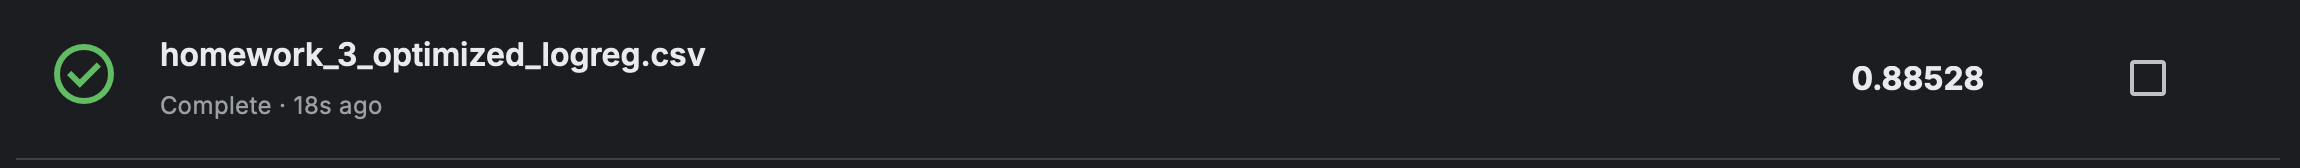

In [5277]:
best_params_cb, best_score_cb = optimize_model("CatBoost", X_train, y_train)
print(f"Best params: {best_params_cb}")
print(f"Best F1-score: {best_score_cb:.4f}")
final_model_cb = CatBoostClassifier(**best_params_cb, random_state=42, verbose=0)
final_model_cb.fit(X_train, y_train, cat_features=cat_features)

preds_cb = final_model_cb.predict(test)
preds_cb = np.array([it[0] for it in preds_cb])
output_df = pd.DataFrame({"Onshore/Offshore": preds_cb})
output_df.to_csv("data/homework_3_optimized_cb.csv", index_label="index")

[I 2025-06-13 02:55:00,843] A new study created in memory with name: no-name-d01c94e6-0726-438b-9cf9-5507593f53f9


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-13 02:55:02,259] Trial 0 finished with value: 0.5629781516850483 and parameters: {'iterations': 233, 'depth': 5, 'learning_rate': 0.19368990376687928, 'l2_leaf_reg': 6.232283543845585, 'random_strength': 0.6954797375165783, 'bagging_temperature': 0.6782096223759907, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.5629781516850483.
[I 2025-06-13 02:55:03,252] Trial 1 finished with value: 0.5855026753696181 and parameters: {'iterations': 61, 'depth': 8, 'learning_rate': 0.26203417337428797, 'l2_leaf_reg': 9.51268637553904, 'random_strength': 0.8142715719069317, 'bagging_temperature': 0.23200687711802062, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.5855026753696181.
[I 2025-06-13 02:55:07,345] Trial 2 finished with value: 0.5935515925431724 and parameters: {'iterations': 288, 'depth': 7, 'learning_rate': 0.1383969145297576, 'l2_leaf_reg': 3.2495313573213584, 'random_strength': 0.4898528716796012, 'bagging_temperature': 0.3548184000345013, 'grow_pol

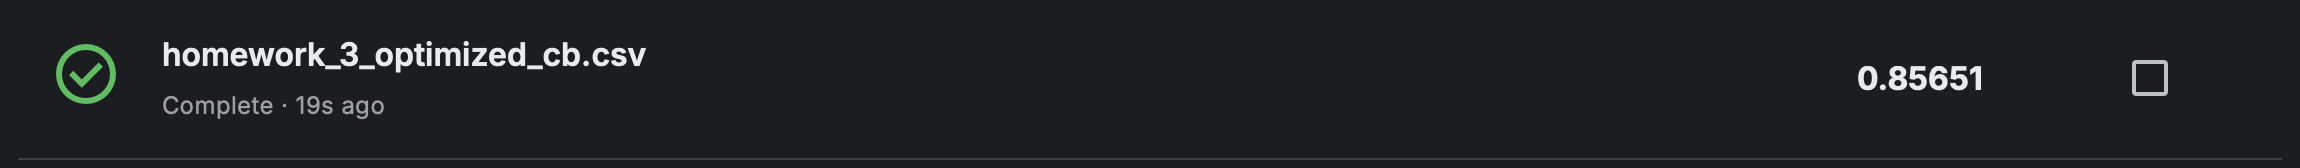

Мы видим, что метрики моделей сопоставимы, однако лучшую точность показывает XGBoost.